# Estimate Membership Activity

There are well-defined gaps in our logbooks, and logbooks largely inform the dataset's membership activity (e.g. subscriptions, renewals, etc.) Given those gaps, how accurately can we predict membership activity over a given time interval?

In [1]:
import pandas as pd
import json
from dateutil.parser import parse as date_parse
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
events_df = pd.read_csv(
    '../dataset_generator/source_data/SCoData_events_v1.1_2021-01.csv',
    parse_dates=['start_date']
)

In [3]:
# Only select membership activity events that are sourced by the logbooks
# Select only the columns that are immediately useful
df = events_df[
    events_df.item_uri.isna() &
    events_df.source_type.str.contains('Logbook')
][[
    'member_names',
    'event_type', 'start_date', 'end_date', 
   'subscription_duration', 'subscription_duration_days',
   'subscription_volumes', 'subscription_category',
   'source_type'
]].dropna(subset=['start_date'])

df['start_date'] = pd.to_datetime(df['start_date'])

# Determine Logbook Gaps

In [4]:
with open('logbook-dates.json') as f:
    logbook_dates = json.load(f)
    for d in logbook_dates:
        d['startDate'] = date_parse(d['startDate'])
        d['endDate'] = date_parse(d['endDate'])

logbook_gaps = []
skipped = []
for i, _ in enumerate(logbook_dates[1:-1]):
    start = logbook_dates[i]['endDate']
    end = logbook_dates[i+1]['startDate']
    interval = end - start
    interval_dict = { 'start': start, 'end': end, 'interval': interval.days }
    if interval.days > 12:
        logbook_gaps.append(interval_dict)
    else:
        skipped.append(interval_dict)

print(f"The {len(logbook_gaps)} large gaps in the logbooks")
for date_dict in logbook_gaps:
    print(f"\t{date_dict['start'].strftime('%B %d %Y')} to {date_dict['end'].strftime('%B %d %Y')} ({date_dict['interval']} days)")

print(f"\nThe {len(skipped)} small gaps in the logbooks that will be skipped")
for date_dict in skipped:
    print(f"\t{date_dict['start'].strftime('%B %d %Y')} to {date_dict['end'].strftime('%B %d %Y')} ({date_dict['interval']} days)")

The 6 large gaps in the logbooks
	December 31 1927 to March 01 1928 (61 days)
	January 02 1930 to June 02 1930 (151 days)
	July 31 1930 to January 01 1931 (154 days)
	February 16 1931 to September 26 1932 (588 days)
	December 31 1936 to February 17 1938 (413 days)
	May 05 1938 to October 21 1938 (169 days)

The 8 small gaps in the logbooks that will be skipped
	December 31 1923 to January 02 1924 (2 days)
	October 29 1927 to November 02 1927 (4 days)
	April 30 1928 to May 01 1928 (1 days)
	December 31 1928 to January 02 1929 (2 days)
	November 30 1929 to December 02 1929 (2 days)
	February 06 1934 to February 09 1934 (3 days)
	December 31 1934 to January 12 1935 (12 days)
	December 28 1935 to January 02 1936 (5 days)


In [5]:
dfs = []
for gap in logbook_gaps:
    dfs.append(df[df['start_date'].between(gap['start'], gap['end'], inclusive=False)])
print(f"Number of membership events that occur during the logbook gaps: {pd.concat(dfs).shape[0]}. (These come from other sources like Lending Cards)")

Number of membership events that occur during the logbook gaps: 33. (These come from other sources like Lending Cards)


## Generate event per day distribution

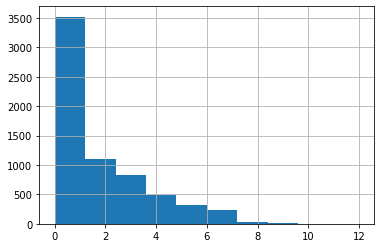

In [6]:
# Calculate distribution of events per day
event_per_day_distribution = df.groupby('start_date').count()['event_type']
# Make distribution continuous
event_per_day_distribution = df.groupby('start_date').count()['event_type']
day_delta = (event_per_day_distribution.index.max() - event_per_day_distribution.index.min()).days
for i in range(day_delta):
    new_date = event_per_day_distribution.index.min() + timedelta(days=i)
    if new_date not in event_per_day_distribution.index:
        event_per_day_distribution.loc[new_date] = 0

# Filter logbook gaps dates out of the dataset
for gap in logbook_gaps:
    event_per_day_distribution = event_per_day_distribution[
        ~((gap['start'] < event_per_day_distribution.index) & (gap['end'] > event_per_day_distribution.index))
    ]

event_per_day_distribution.hist()

## Calculation Summary

In [7]:
number_of_missing_days = sum([date_dict['interval'] for date_dict in logbook_gaps])
missing_membership_event_count = event_per_day_distribution.median() * number_of_missing_days

surviving_membership_event_count = events_df[events_df.item_uri.isna()].shape[0]

# Calculations
total_membership_event_count = surviving_membership_event_count + missing_membership_event_count  # Assumption by definition that all membership events would be included in the logbook
percent_surviving_membership_events = round(surviving_membership_event_count / total_membership_event_count * 100, 2)

# Results
print(f"Number of days missing: {number_of_missing_days}")
print(f"Surviving membership activity event count: {surviving_membership_event_count}")
print(f"Estimated total number of membership events: {total_membership_event_count}")
print(f"Estimated number of missing membership events: {int(missing_membership_event_count)}")
print(f"Estimated percent of surviving membership events: {float(percent_surviving_membership_events)}")

Number of days missing: 1536
Surviving membership activity event count: 12552
Estimated total number of membership events: 14088.0
Estimated number of missing membership events: 1536
Estimated percent of surviving membership events: 89.1
